In [47]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp # for reference

import autograd.numpy as np
from neuralsolver import NNSolver

import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
import time

# figure settings
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['legend.fontsize'] = 13

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 15

In [48]:
def plot_loss_compare(model, maxiter = 1000, iprint = 200):
    model.reset_weights()
    save_init_paras_list = model.params_list
    save_init_flattened_params = model.flattened_params
    
    
    methods = ['CG','BFGS','L-BFGS-B']
    
    plt.figure(figsize=(8,6))
    for method in methods:
        
        model.params_list = save_init_paras_list
        model.flattened_params = save_init_flattened_params
        
        start_time = time.time()
        model.train(method = method, maxiter=maxiter, iprint=iprint)
        duration = time.time() - start_time
        
        plt.semilogy(range(len(model.loss)), model.loss, label = method + ' (time = {}s'.format(round(duration,2)) + ')')
        
    plt.legend()
    plt.title("Log Loss Comparision", fontsize = 20)
    plt.xlabel("Iteration")
    plt.ylabel("Log Loss")
    plt.show()

# Problem Definition

In [57]:
# Van der Pol oscillator
#http://kitchingroup.cheme.cmu.edu/blog/2013/02/02/Solving-a-second-order-ode/

mu = 1.
def f(t, y):
    # dx/dt = mu(x - 1/3*x**3 - y)
    # dy/dt = mu/x
    return [mu*(y[0] - (y[0]**3)/3. - y[1]), y[0]/mu]


y0_list = [1, 2] 

t = np.linspace(0, 10, 40).reshape(-1, 1) #training points
# use non-uniform spacing instead
#t = np.concatenate([np.linspace(0, 4, 20), np.linspace(4.1, 10, 15)])
t = t.reshape(-1, 1)

# Reference solution

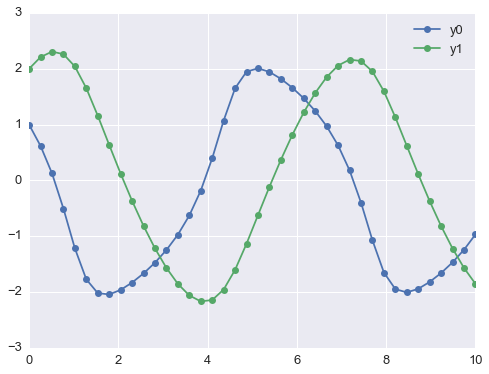

In [58]:
# reference solution using scipy package
sol = solve_ivp(f, [t.min(), t.max()], y0_list, 
                t_eval=t.ravel(), method='Radau', rtol=1e-5)
plt.plot(sol.t, sol.y[0], marker='o', label='y0')
plt.plot(sol.t, sol.y[1], marker='o', label='y1')
plt.legend()

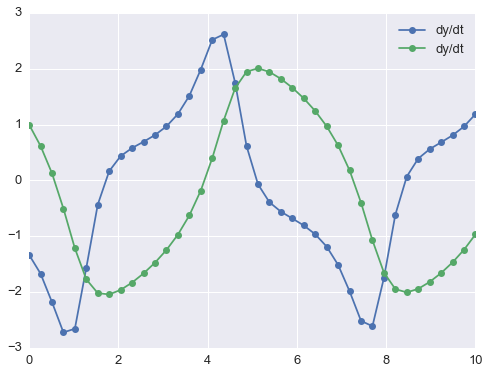

In [59]:
# reference solution using scipy package
plt.plot(sol.t, f(sol.t, sol.y)[0], marker='o', label='dy/dt')
plt.plot(sol.t, f(sol.t, sol.y)[1], marker='o', label='dy/dt')
plt.legend()

# Neural Net Training

In [65]:
nn = NNSolver(f, t, y0_list, n_hidden=20)
nn

Neural ODE Solver 
Number of equations:       2 
Initial condition y0:      [1, 2] 
Numnber of hidden units:   20 
Number of training points: 40 

In [66]:
nn.reset_weights()
%time nn.train(maxiter=1000, iprint=100)

iteration: 0 loss:  131.590730731
iteration: 100 loss:  0.157539995831
iteration: 200 loss:  0.1560103991
iteration: 300 loss:  0.155095851952
iteration: 400 loss:  0.103345926097
iteration: 500 loss:  0.0322350418167
iteration: 600 loss:  0.00889959020577
iteration: 700 loss:  0.00414863023537
iteration: 800 loss:  0.00314122550224
iteration: 900 loss:  0.00254305758139
         Current function value: 0.002301
         Iterations: 1000
         Function evaluations: 1092
         Gradient evaluations: 1092
CPU times: user 11.9 s, sys: 56.5 ms, total: 11.9 s
Wall time: 12 s


# Verifying training set

In [ ]:
y_pred_list, dydt_pred_list = nn.predict()

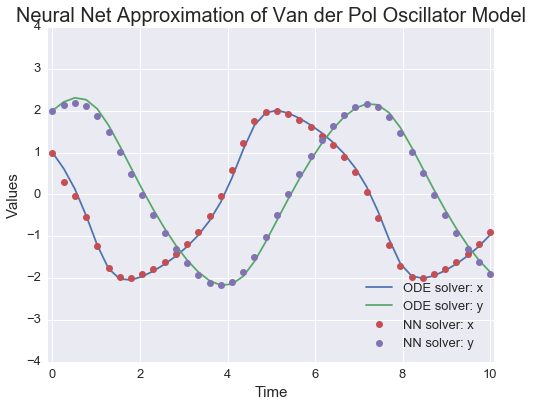

In [83]:
# scipy sol
plt.figure(figsize= (8, 6))
plt.plot(sol.t, sol.y[0], label='ODE solver: x')
plt.plot(sol.t, sol.y[1], label='ODE solver: y')
# nn soln
plt.plot(t, y_pred_list[0], 'o', label='NN solver: x')
plt.plot(t, y_pred_list[1], 'o', label='NN solver: y')

plt.legend(loc = 'best')
plt.xlim((-0.1, 10.1))
plt.ylim((-4, 4))

plt.title('Neural Net Approximation of Van der Pol Oscillator Model')
plt.ylabel('Values')
plt.xlabel('Time')

In [84]:
np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(2)])

0.099899852109968434

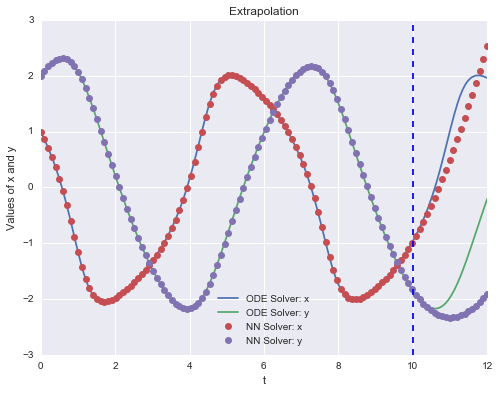

In [11]:
# not used
t_test = np.linspace(0., 12.0, 120).reshape(-1,1)

sol = solve_ivp(f, [t_test.min(), t_test.max()], y0_list, method='Radau', rtol=1e-5)
y_pred_list, dydt_pred_list = nn.predict(t=t_test)
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y[0], label='ODE Solver: x')
plt.plot(sol.t, sol.y[1], label='ODE Solver: y')

plt.plot(t_test, y_pred_list[0], 'o', label='NN Solver: x')
plt.plot(t_test, y_pred_list[1], 'o', label='NN Solver: y')
plt.axvline(x = 10 , linestyle = '--')
plt.legend(loc = 'best')
plt.title('Extrapolation')
plt.ylabel('Values of x and y')
plt.xlabel('t')

In [92]:
res_arr = []
for _ in range(100):
    nn = NNSolver(f, t, y0_list, n_hidden=20)
    nn.reset_weights()
    nn.train(maxiter=500)
    y_pred_list, dydt_pred_list = nn.predict()
    res_arr.append(np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(2)]))

iteration: 0 loss:  2609910.80836
iteration: 200 loss:  0.15822526615
iteration: 400 loss:  0.116263700936
         Current function value: 0.079668
         Iterations: 500
         Function evaluations: 565
         Gradient evaluations: 565
iteration: 0 loss:  561.472246343
iteration: 200 loss:  0.154830685939
iteration: 400 loss:  0.0852663010946
         Current function value: 0.040148
         Iterations: 500
         Function evaluations: 595
         Gradient evaluations: 586
iteration: 0 loss:  594.321642745
iteration: 200 loss:  0.156341859686
iteration: 400 loss:  0.154131195538
         Current function value: 0.080877
         Iterations: 500
         Function evaluations: 572
         Gradient evaluations: 572
iteration: 0 loss:  3580580.68008
iteration: 200 loss:  0.157061375769
iteration: 400 loss:  0.0831343703452
         Current function value: 0.025784
         Iterations: 500
         Function evaluations: 588
         Gradient evaluations: 586
iteration: 0 loss: 

(array([ 76.,   7.,   4.,   2.,   1.,   4.,   2.,   2.,   0.,   2.]), array([  0.03210086,   3.20188502,   6.37166917,   9.54145332,
        12.71123747,  15.88102162,  19.05080578,  22.22058993,
        25.39037408,  28.56015823,  31.72994238]), <a list of 10 Patch objects>)


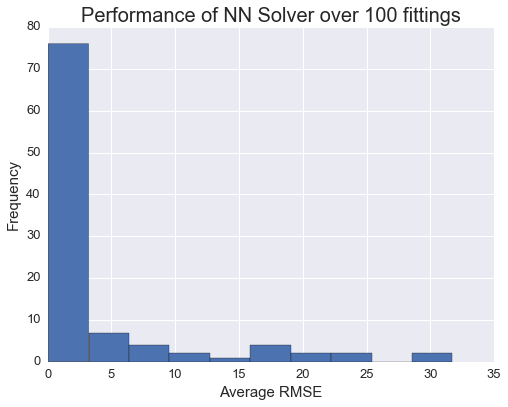

In [93]:
plt.figure(figsize= (8, 6))
figr = plt.hist(res_arr)
plt.title('Performance of NN Solver over 100 fittings')
plt.xlabel('Average RMSE')
plt.ylabel('Frequency')
print (figr)

## Compare across different optimization methods

iteration: 0 loss:  269.559249682
iteration: 200 loss:  0.212924582849
iteration: 400 loss:  0.174044537294
iteration: 600 loss:  0.168716611731
iteration: 800 loss:  0.167977453644
         Current function value: 0.167178
         Iterations: 1000
         Function evaluations: 1914
         Gradient evaluations: 1914
iteration: 0 loss:  269.559249682
iteration: 200 loss:  0.158455953891
iteration: 400 loss:  0.154988130607
iteration: 600 loss:  0.0408102675831
iteration: 800 loss:  0.0109366122091
         Current function value: 0.003859
         Iterations: 1000
         Function evaluations: 1084
         Gradient evaluations: 1084
iteration: 0 loss:  266.740559394
iteration: 200 loss:  0.17487382753
iteration: 400 loss:  0.167929701168
iteration: 600 loss:  0.166350944007
iteration: 800 loss:  0.165556013767
iteration: 1000 loss:  0.16480340751


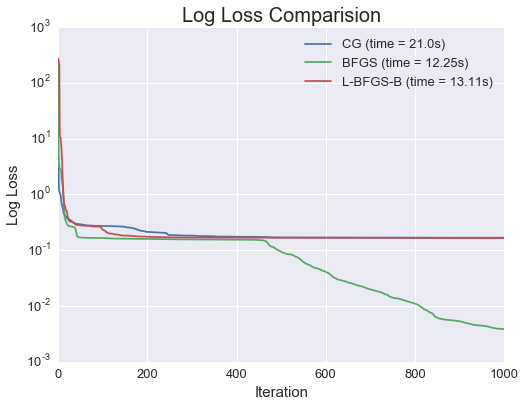

In [91]:
plot_loss_compare(nn)